# Regression Project - Group 2
#### Samer Alsaadi | Alexandre Beaubien | Mehmet Yazkanoglu  

<br>

## Regrssion Discontinuity Design using Covid-19 data

Prefix:

- Data used in this analysis was sourced from    
<br>
- The variable used to establish events threshold is <strong>Date</strong>.  
<br>
- The variables used to measure change are <strong>Number of Cases per Day</strong> and <strong>Rolling 7-Day Average</strong>.  
<br>
- One model observed a better fit using regression of degree <strong>1</strong> and the rest using polynomial degree <strong>2</strong>.


In [1]:
# Import Packages

#Data Analysis
import numpy as np
import pandas as pd
import datetime as dt

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Machine Learning
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
# Import dataset
covid = pd.read_csv("data/Quebec Covid-19.csv")

# Filter dataset to Quebec only
covid = covid.loc[covid['prname'] == 'Quebec']

# Remove unwanted columns
covid.drop(['pruid', 'prnameFR', 'numprob', 'update', 'numtested', 'numtests', 'numrecover', 'percentrecover','ratetested', 'ratetests', 'percentoday', 'ratetotal', 'ratedeaths',
            'percentdeath', 'numtestedtoday', 'numteststoday', 'numrecoveredtoday','percentactive', 'rateactive', 'numtotal_last14', 'ratetotal_last14', 'ratedeaths_last14',
            'numdeaths_last14', 'ratetotal_last7', 'ratedeaths_last7', 'avgtotal_last7','avgincidence_last7', 'avgdeaths_last7', 'avgratedeaths_last7', 'raterecovered'], axis = 1, inplace = True)

# Convert date to datetime object
covid['date'] = pd.to_datetime(covid['date'])

# Extract Year, Month and Day from Date column
covid['date_year'] = covid['date'].dt.year
covid['date_month'] = covid['date'].dt.month.map("{:02}".format) # Add 0 to single digit months
covid['date_day'] = covid['date'].dt.day.map("{:02}".format) # Add 0 to single digit days

# Convert to int
covid['date_month'] = pd.to_numeric(covid['date_month'])
covid['date_day'] = pd.to_numeric(covid['date_day'])

# Deal with N/A values
# Only num_total_last7 and numdeaths_last7 have minimal empty values due to the nature of the variable. Fill empty values with 0
covid['numtotal_last7'].fillna(0, inplace = True)
covid['numdeaths_last7'].fillna(0, inplace = True)

In [3]:
# Lets build a more appropriate 'date' variable

# Reset the index after cleanup
covid.reset_index(inplace = True)

# New column to match index value
covid['dayfromstart'] = covid.index

### Model for 20/30/2020 Lockdown (Order 1)

In [4]:
# New sub-dataframe that contains only the records needed
lockdown1 = covid[6:27]

# Variable that holds categorigal values to indicate before/after values
lockdown1['lockdown1'] = np.where(lockdown1['dayfromstart'] > 16, 'before', 'after')

# Independent variable
lockdown1['lockdown1_date'] = lockdown1['dayfromstart'] - 16

# Order 1 regression
rdd1_order1 = "numtoday ~ 1 + C(lockdown1) + lockdown1_date"

m1_order1 = smf.ols(rdd1_order1, lockdown1).fit(cov_type = 'HC2')
print(m1_order1.summary())

                            OLS Regression Results                            
Dep. Variable:               numtoday   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     31.74
Date:                Sat, 08 Jan 2022   Prob (F-statistic):           1.25e-06
Time:                        17:26:14   Log-Likelihood:                -125.63
No. Observations:                  21   AIC:                             257.3
Df Residuals:                      18   BIC:                             260.4
Df Model:                           2                                         
Covariance Type:                  HC2                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                116

<ipython-input-4-48f30278b0db>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lockdown1['lockdown1'] = np.where(lockdown1['dayfromstart'] > 16, 'before', 'after')
<ipython-input-4-48f30278b0db>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lockdown1['lockdown1_date'] = lockdown1['dayfromstart'] - 16


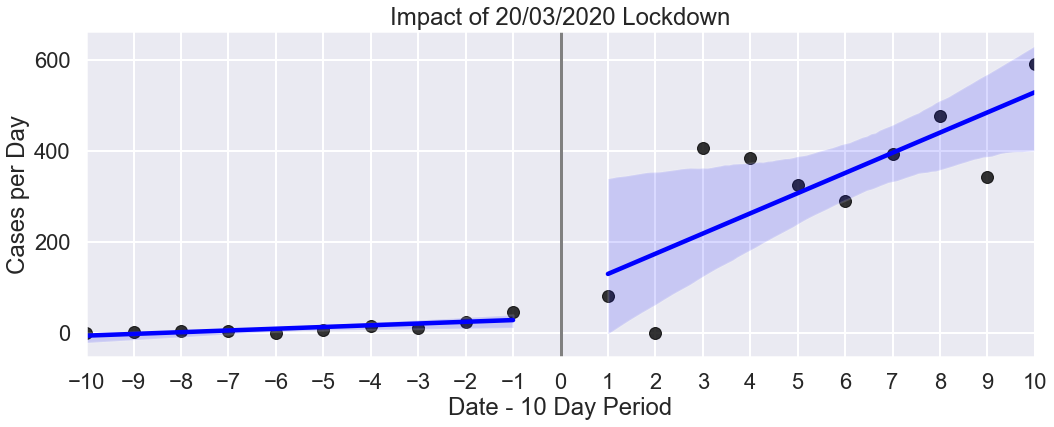

In [5]:
# Create two models for before/after event
beforelock1 = lockdown1[lockdown1['lockdown1_date'] < 0]
afterlock1 = lockdown1[lockdown1['lockdown1_date'] > 0]

# Variable that we need to measure its change
y1 = beforelock1['numtoday']
y2 = afterlock1['numtoday']

# Independent Variable
x1 = beforelock1['lockdown1_date']
x2 = afterlock1['lockdown1_date']

# Create figure
sns.set_context("poster")
fig,ax = plt.subplots(figsize=(17, 6))
ax.set_title('Impact of 20/03/2020 Lockdown')

sns.regplot(x = x1, y = y1, order = 1, ax= ax, scatter_kws={"color": "black"}, line_kws = {"color": "blue"})
sns.regplot(x = x2, y = y2, order = 1, ax= ax, scatter_kws={"color": "black"}, line_kws = {"color": "blue"})

plt.axvline(x = 0, color = 'grey')
ax.set_xticks(range(-10,11))
ax.set(xlabel = 'Date - 10 Day Period', ylabel = 'Cases per Day')
plt.show()

### Model for 20/30/2020 Lockdown (Order 2)

In [6]:
# New sub-dataframe that contains only the records needed
lockdown1 = covid[6:27]

# Variable that holds categorigal values to indicate before/after values
lockdown1['lockdown1'] = np.where(lockdown1['dayfromstart'] > 16, 'before', 'after')

# Independent variable
lockdown1['lockdown1_date'] = lockdown1['dayfromstart'] - 16

# Order 2 regression
rdd1_order2 = "numtoday ~ 1 + C(lockdown1) + lockdown1_date + I(lockdown1_date**2)"

m1_order2 = smf.ols(rdd1_order2, lockdown1).fit(cov_type = 'HC2')
print(m1_order2.summary())

                            OLS Regression Results                            
Dep. Variable:               numtoday   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     42.07
Date:                Sat, 08 Jan 2022   Prob (F-statistic):           4.41e-08
Time:                        17:26:14   Log-Likelihood:                -121.01
No. Observations:                  21   AIC:                             250.0
Df Residuals:                      17   BIC:                             254.2
Df Model:                           3                                         
Covariance Type:                  HC2                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 63

<ipython-input-6-d1358a8952dd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lockdown1['lockdown1'] = np.where(lockdown1['dayfromstart'] > 16, 'before', 'after')
<ipython-input-6-d1358a8952dd>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lockdown1['lockdown1_date'] = lockdown1['dayfromstart'] - 16


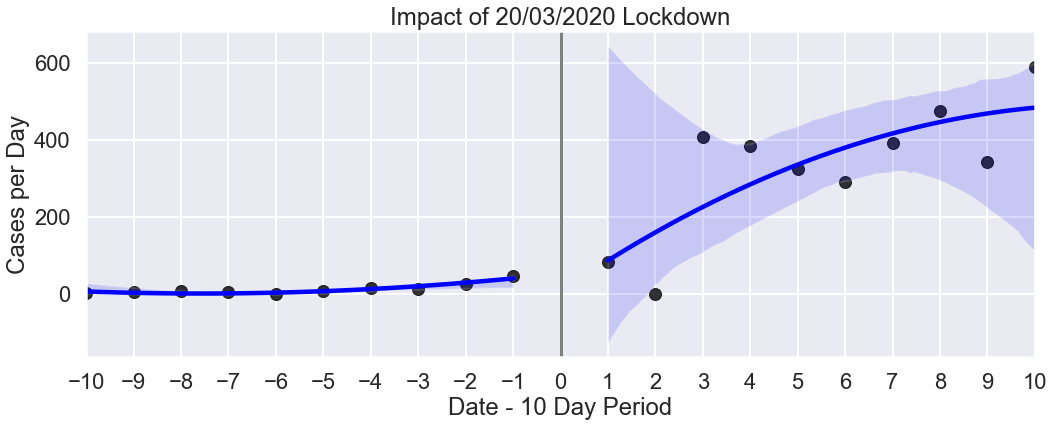

In [7]:
# Create two models for before/after event
beforelock1 = lockdown1[lockdown1['lockdown1_date'] < 0]
afterlock1 = lockdown1[lockdown1['lockdown1_date'] > 0]

# Variable that we need to measure its change
y1 = beforelock1['numtoday']
y2 = afterlock1['numtoday']

# Independent Variable
x1 = beforelock1['lockdown1_date']
x2 = afterlock1['lockdown1_date']

# Create figure
sns.set_context("poster")
fig,ax = plt.subplots(figsize=(17, 6))
ax.set_title('Impact of 20/03/2020 Lockdown')

# Change order to 2
sns.regplot(x = x1, y = y1, order = 2, ax= ax, scatter_kws={"color": "black"}, line_kws = {"color": "blue"})
sns.regplot(x = x2, y = y2, order = 2, ax= ax, scatter_kws={"color": "black"}, line_kws = {"color": "blue"})

plt.axvline(x = 0, color = 'grey')
ax.set_xticks(range(-10,11))
ax.set(xlabel = 'Date - 10 Day Period', ylabel = 'Cases per Day')
plt.show()

### Model for 30/08/2020 School Opening (Order 1)

In [8]:
# New sub-dataframe that contains only the records needed
schoolopen = covid[166:195]

# Variable that holds categorigal values to indicate before/after values
schoolopen['schoolopen'] = np.where(schoolopen['dayfromstart'] > 180, 'before', 'after')

# Independent variable
schoolopen['schoolopen_date'] = schoolopen['dayfromstart'] - 180

# Order 1 regression
rdd2_order1 = "numtotal_last7 ~ 1 + C(schoolopen) + schoolopen_date"

m2_order1 = smf.ols(rdd2_order1, schoolopen).fit(cov_type = 'HC2')
print(m2_order1.summary())

                            OLS Regression Results                            
Dep. Variable:         numtotal_last7   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     129.1
Date:                Sat, 08 Jan 2022   Prob (F-statistic):           3.15e-14
Time:                        17:26:15   Log-Likelihood:                -174.35
No. Observations:                  29   AIC:                             354.7
Df Residuals:                      26   BIC:                             358.8
Df Model:                           2                                         
Covariance Type:                  HC2                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

<ipython-input-8-cf4bf46fe88d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  schoolopen['schoolopen'] = np.where(schoolopen['dayfromstart'] > 180, 'before', 'after')
<ipython-input-8-cf4bf46fe88d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  schoolopen['schoolopen_date'] = schoolopen['dayfromstart'] - 180


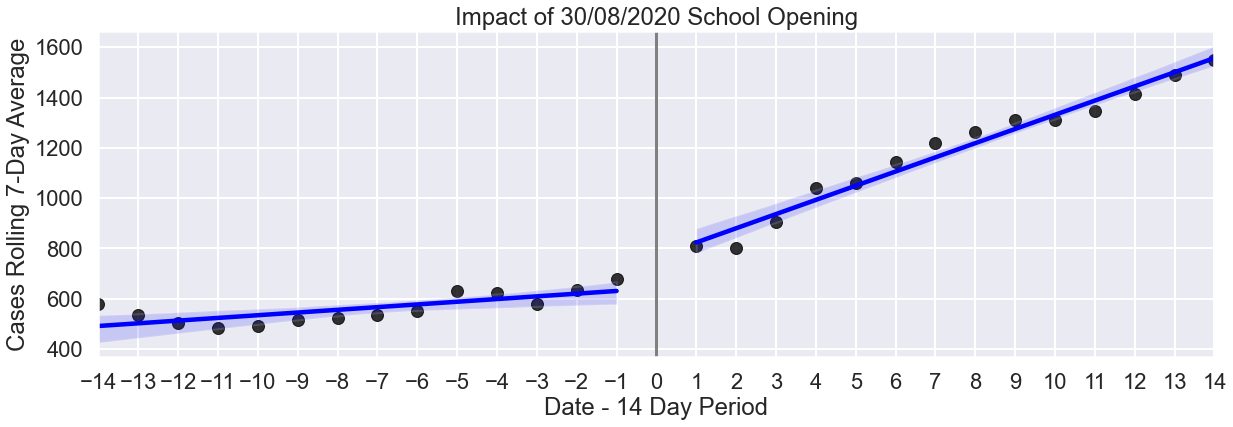

In [9]:
# Create two models for before/after event
beforeschool = schoolopen[schoolopen['schoolopen_date'] < 0]
afterschool = schoolopen[schoolopen['schoolopen_date'] > 0]

# Variable that we need to measure its change
y1 = beforeschool['numtotal_last7']
y2 = afterschool['numtotal_last7']

# Independent Variable
x1 = beforeschool['schoolopen_date']
x2 = afterschool['schoolopen_date']

# Create figure
sns.set_context("poster")
fig,ax = plt.subplots(figsize=(20, 6))
ax.set_title('Impact of 30/08/2020 School Opening')

sns.regplot(x = x1, y = y1, order = 1, ax= ax, scatter_kws={"color": "black"}, line_kws = {"color": "blue"})
sns.regplot(x = x2, y = y2, order = 1, ax= ax, scatter_kws={"color": "black"}, line_kws = {"color": "blue"})

plt.axvline(x = 0, color = 'grey')
ax.set_xticks(range(-14,15))
ax.set(xlabel = 'Date - 14 Day Period', ylabel = 'Cases Rolling 7-Day Average')
plt.show()

### Model for 30/08/2020 School Opening (Order 2)

In [10]:
# New sub-dataframe that contains only the records needed
schoolopen = covid[166:195]

# Variable that holds categorigal values to indicate before/after values
schoolopen['schoolopen'] = np.where(schoolopen['dayfromstart'] > 180, 'before', 'after')

# Independent variable
schoolopen['schoolopen_date'] = schoolopen['dayfromstart'] - 180

# Order 2 regression
rdd2_order2 = "numtotal_last7 ~ 1 + C(schoolopen) + schoolopen_date + I(schoolopen_date**2)"

m2_order2 = smf.ols(rdd2_order2, schoolopen).fit(cov_type = 'HC2')
print(m2_order2.summary())

                            OLS Regression Results                            
Dep. Variable:         numtotal_last7   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     772.9
Date:                Sat, 08 Jan 2022   Prob (F-statistic):           9.16e-25
Time:                        17:26:15   Log-Likelihood:                -150.10
No. Observations:                  29   AIC:                             308.2
Df Residuals:                      25   BIC:                             313.7
Df Model:                           3                                         
Covariance Type:                  HC2                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

<ipython-input-10-ff0e47da0397>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  schoolopen['schoolopen'] = np.where(schoolopen['dayfromstart'] > 180, 'before', 'after')
<ipython-input-10-ff0e47da0397>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  schoolopen['schoolopen_date'] = schoolopen['dayfromstart'] - 180


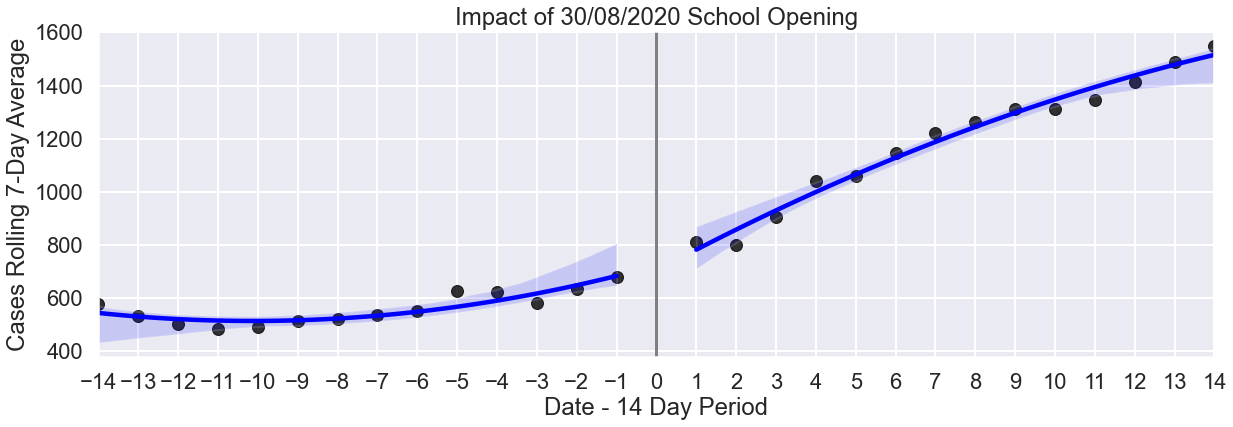

In [11]:
# Create two models for before/after event
beforeschool = schoolopen[schoolopen['schoolopen_date'] < 0]
afterschool = schoolopen[schoolopen['schoolopen_date'] > 0]

# Variable that we need to measure its change
y1 = beforeschool['numtotal_last7']
y2 = afterschool['numtotal_last7']

# Independent Variable
x1 = beforeschool['schoolopen_date']
x2 = afterschool['schoolopen_date']

# Create figure
sns.set_context("poster")
fig,ax = plt.subplots(figsize=(20, 6))
ax.set_title('Impact of 30/08/2020 School Opening')

sns.regplot(x = x1, y = y1, order = 2, ax= ax, scatter_kws={"color": "black"}, line_kws = {"color": "blue"})
sns.regplot(x = x2, y = y2, order = 2, ax= ax, scatter_kws={"color": "black"}, line_kws = {"color": "blue"})

plt.axvline(x = 0, color = 'grey')
ax.set_xticks(range(-14,15))
ax.set(xlabel = 'Date - 14 Day Period', ylabel = 'Cases Rolling 7-Day Average')
plt.show()

### Model for 25/12/2020 lockdown (Order 1)

In [12]:
# New sub-dataframe that contains only the records needed
lockdown2 = covid[275:318]

# Variable that holds categorigal values to indicate before/after values
lockdown2['lockdown2'] = np.where(lockdown2['dayfromstart'] > 296, 'before', 'after')

# Independent variable
lockdown2['lockdown2_date'] = lockdown2['dayfromstart'] - 296

# Order 1 regression
rdd3_order1 = "numtotal_last7 ~ 1 + C(lockdown2) + lockdown2_date"

m3_order1 = smf.ols(rdd3_order1, lockdown2).fit(cov_type = 'HC2')
print(m3_order1.summary())

                            OLS Regression Results                            
Dep. Variable:         numtotal_last7   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     140.2
Date:                Sat, 08 Jan 2022   Prob (F-statistic):           8.45e-19
Time:                        17:26:16   Log-Likelihood:                -354.06
No. Observations:                  43   AIC:                             714.1
Df Residuals:                      40   BIC:                             719.4
Df Model:                           2                                         
Covariance Type:                  HC2                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               1.36

<ipython-input-12-498797337bc5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lockdown2['lockdown2'] = np.where(lockdown2['dayfromstart'] > 296, 'before', 'after')
<ipython-input-12-498797337bc5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lockdown2['lockdown2_date'] = lockdown2['dayfromstart'] - 296


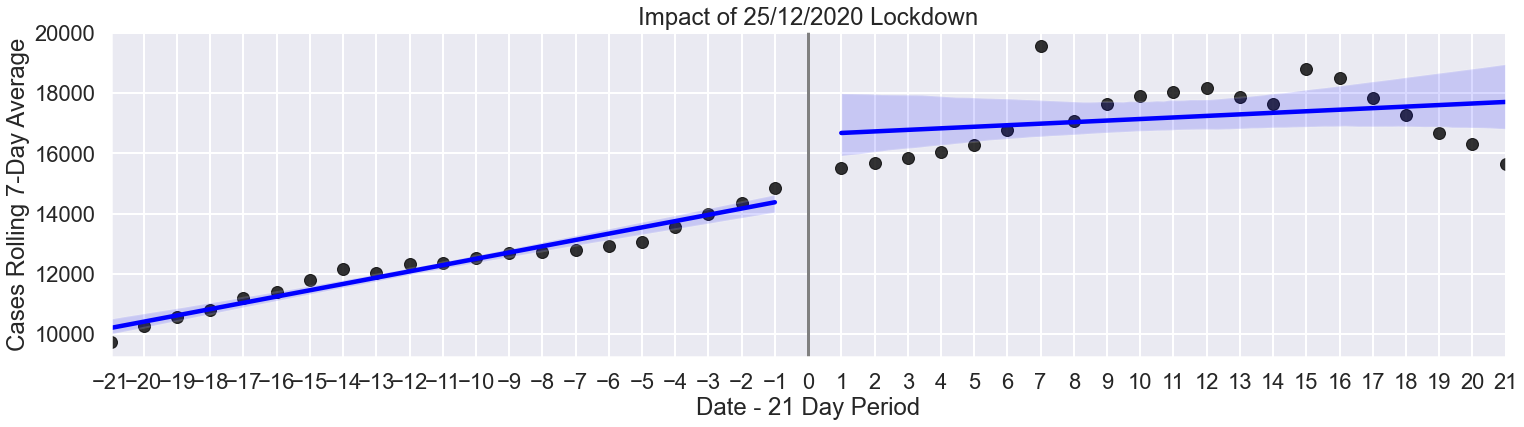

In [13]:
# Create two models for before/after event
beforelock2 = lockdown2[lockdown2['lockdown2_date'] < 0]
afterlock2 = lockdown2[lockdown2['lockdown2_date'] > 0]

# Variable that we need to measure its change
y1 = beforelock2['numtotal_last7']
y2 = afterlock2['numtotal_last7']

# Independent Variable
x1 = beforelock2['lockdown2_date']
x2 = afterlock2['lockdown2_date']

# Create figure
sns.set_context("poster")
fig,ax = plt.subplots(figsize=(25, 6))
ax.set_title('Impact of 25/12/2020 Lockdown')

# Change order to 2
sns.regplot(x = x1, y = y1, order = 1, ax= ax, scatter_kws={"color": "black"}, line_kws = {"color": "blue"})
sns.regplot(x = x2, y = y2, order = 1, ax= ax, scatter_kws={"color": "black"}, line_kws = {"color": "blue"})

plt.axvline(x = 0, color = 'grey')
ax.set_xticks(range(-21,22))
ax.set(xlabel = 'Date - 21 Day Period', ylabel = 'Cases Rolling 7-Day Average')
plt.show()

### Model for 25/12/2020 lockdown (Order 2)

In [14]:
# New sub-dataframe that contains only the records needed
lockdown2 = covid[275:318]

# Variable that holds categorigal values to indicate before/after values
lockdown2['lockdown2'] = np.where(lockdown2['dayfromstart'] > 296, 'before', 'after')

# Independent variable
lockdown2['lockdown2_date'] = lockdown2['dayfromstart'] - 296

# Order 1 regression
rdd3_order2 = "numtotal_last7 ~ 1 + C(lockdown2) + lockdown2_date + I(lockdown2_date**2)"

m3_order2 = smf.ols(rdd3_order2, lockdown2).fit(cov_type = 'HC2')
print(m3_order2.summary())

                            OLS Regression Results                            
Dep. Variable:         numtotal_last7   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     274.8
Date:                Sat, 08 Jan 2022   Prob (F-statistic):           2.93e-26
Time:                        17:26:17   Log-Likelihood:                -344.65
No. Observations:                  43   AIC:                             697.3
Df Residuals:                      39   BIC:                             704.3
Df Model:                           3                                         
Covariance Type:                  HC2                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                1.4

<ipython-input-14-d51b97a5d000>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lockdown2['lockdown2'] = np.where(lockdown2['dayfromstart'] > 296, 'before', 'after')
<ipython-input-14-d51b97a5d000>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lockdown2['lockdown2_date'] = lockdown2['dayfromstart'] - 296


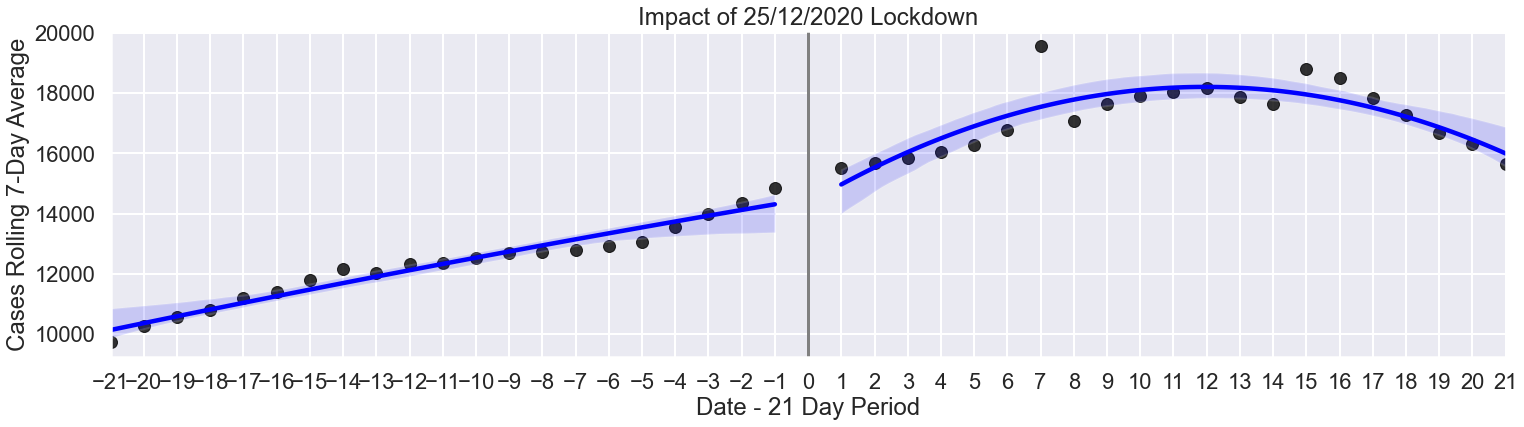

In [15]:
# Create two models for before/after event
beforelock2 = lockdown2[lockdown2['lockdown2_date'] < 0]
afterlock2 = lockdown2[lockdown2['lockdown2_date'] > 0]

# Variable that we need to measure its change
y1 = beforelock2['numtotal_last7']
y2 = afterlock2['numtotal_last7']

# Independent Variable
x1 = beforelock2['lockdown2_date']
x2 = afterlock2['lockdown2_date']

# Create figure
sns.set_context("poster")
fig,ax = plt.subplots(figsize=(25, 6))
ax.set_title('Impact of 25/12/2020 Lockdown')

# Change order to 2
sns.regplot(x = x1, y = y1, order = 2, ax= ax, scatter_kws={"color": "black"}, line_kws = {"color": "blue"})
sns.regplot(x = x2, y = y2, order = 2, ax= ax, scatter_kws={"color": "black"}, line_kws = {"color": "blue"})

plt.axvline(x = 0, color = 'grey')
ax.set_xticks(range(-21,22))
ax.set(xlabel = 'Date - 21 Day Period', ylabel = 'Cases Rolling 7-Day Average')
plt.show()